# Contact randomization and simulation results comaprison
In this notebook the randomization fo the contact structure is preformed. Then the simulation of the disease diffusion process is prerformed and the results are compared.

PORÓWNANIE MONTE CARLO Z LOSOWYM WIERZHCOŁKIEM DLA KONTAKTÓW ZE ZBIORU DANYCH I KONTAKTÓW,KTÓRE WYLOSOWAŁAM
W tym pliku następuje randomizacja kontaktów, tzn. czasy są takie same, ale wierzchołki między, którymi doszło do infekcji są różne. Następnie dla tak sporządzonej listy kontaktów, puszczam symulację epidemii z losowo wybranym wierzchołkiem 1000 razy, aby zobaczyć, czy efekt będzie ten sam

In [1]:
#DANE+ BIBLIOTEKI
%store -r G 
%store -r S_normal #to z PRACA 1, czyli ile osób zarazi przy losowym wyborze 
import networkx as nx
import matplotlib.pyplot as plt
import random
import statistics
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

no stored variable #to z PRACA 1, czyli ile osób zarazi przy losowym wyborze


In [2]:
data=open("C:/Users/wojci/Documents/Studia/praca/DANE/dane.txt","r")
data=data.readlines()
times=[]
#OBRÓBKA DANYCH
for i in range(0,len(data)):
    row=data[i]
    row=row.split()
    times.append(int(row[0])/60/60/24)

def random_contact_list():
    contacts=[]
    for i in range(0,len(times)):
        node1=0
        node2=0
        while node1==node2:
            node1=random.choice(list(G.nodes))
            node2=random.choice(list(G.nodes))
        contacts.append((times[i],node1,node2))
        
    return contacts



In [3]:
inf_prob=0.006
incubation_period=1
infectious_period=7

def clear_net():
    for i in list(G.nodes):
        G.nodes[i]['state']="S"
        G.nodes[i]['time_of_inf']=False
    G.graph['time']=0
    G.graph['E']=0
    G.graph['S']=92
    G.graph['I']=0
    G.graph['R']=0
    
def new_exposed(node,time):
    G.graph['E']+=1
    G.graph['S']-=1
    G.nodes[node]['state']='E'
    G.nodes[node]['time_of_inf']=time
    
def transformations():
    for i in list(G.nodes):
        #end of incubation
        if G.nodes[i]['state']=="E":
            if G.nodes[i]['time_of_inf']+incubation_period<=G.graph['time']:
                G.nodes[i]['state']="I"
                G.graph['E']-=1
                G.graph['I']+=1
            
        #end of infectiousness ->passing to recovered
        if G.nodes[i]['state']=='I':
            if G.nodes[i]['time_of_inf']+incubation_period+infectious_period<=G.graph['time']:
                G.nodes[i]['state']="R"
                G.nodes[i]['time_of_inf']=False
                G.graph['I']-=1
                G.graph['R']+=1

def new_contact(node1,node2,time):
    
    if G.nodes[node1]['state']=='I'and G.nodes[node2]['state']=='S':
        pr=random.random() 
        if pr<=inf_prob: #udało się zarazić
            G.nodes[node2]['state']='E'
            G.nodes[node2]['time_of_inf']=time
            G.graph['E']+=1
            G.graph['S']-=1
                
    if G.nodes[node2]['state']=='I'and G.nodes[node1]['state']=='S':
        pr=random.random() 
        if pr<=inf_prob: #udało się zarazić
            G.nodes[node1]['state']='E'
            G.nodes[node1]['time_of_inf']=time
            G.graph['E']+=1
            G.graph['S']-=1
            
def epidemics(node):
    S=[]
    E=[]
    I=[]
    R=[]
    clear_net()
    new_exposed(node,0)
    times=[G.graph['time']]
    
    for i in contacts:
        
        if times[-1]!=i[0]:
            G.graph['time']=i[0]
            transformations()
            times.append(G.graph['time'])
            var=True
            
        new_contact(i[1],i[2],i[0])
        
        if var==True:
            S.append(G.graph['S'])
            E.append(G.graph['E'])
            R.append(G.graph['R'])
            I.append(G.graph['I'])
        
            
    return [S,E,I,R]

def simple_epidemics(node,contacts): #used for MC simulation
    clear_net()
    new_exposed(node,0)
    for i in contacts:
        G.graph['time']=i[0]
        transformations()
        new_contact(i[1],i[2],i[0])
    return G.graph['S']

In [12]:
#contacts=random_contact_list()
%store -r random_contacts
nodes_list=list(G.nodes)
N=1000
S=[92-simple_epidemics(random.choice(nodes_list),random_contacts) for j in range(0,N)]

Stored 'S_random' (list)


(array([629., 143.,  92.,  52.,  47.,  16.,   9.,   5.,   4.,   3.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

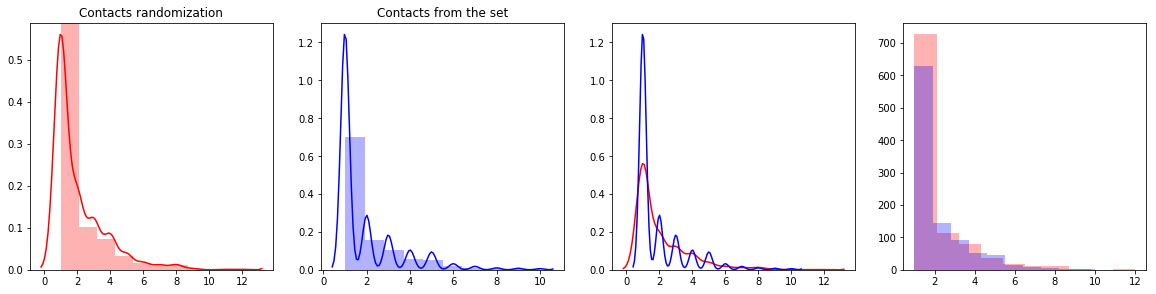

In [13]:
S_random=S
%store S_random
#%store -r S_random
plt.figure(figsize=(20,10)) 

plt.subplot(2,4,1)
sns.kdeplot(S_random, color="r")
plt.hist(S_random,alpha=0.3,color='r',density=True)
plt.title('Contacts randomization')
plt.subplot(2,4,2)
sns.kdeplot(S_normal, color="b")
plt.hist(S_normal,alpha=0.3,color='b',density=True)
plt.title('Contacts from the set')

plt.subplot(2,4,3)
sns.kdeplot(S_random, color="r")
sns.kdeplot(S_normal, color="b")

plt.subplot(2,4,4)
plt.hist(S_random,alpha=0.3,color='r')
plt.hist(S_normal,alpha=0.3,color='b')


Ostatni histogram ile było osób chorych dla każdej z symulacji histogramy, no niby podobnie...., ale jak się unormuje, to widać różnicę... Ta randomizacja to ona jest trochę nieprawdziwa, bo przecież te kontakty nie ukłądały się równomiernie, a tu losuję z takim samym prawdopodobieństwem każdy wierzchołek

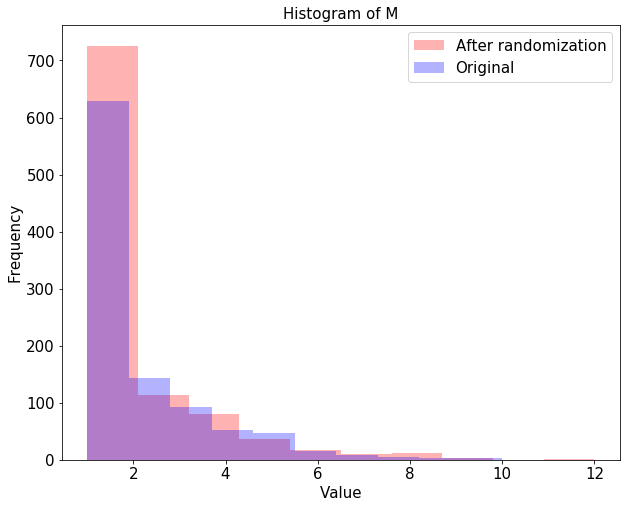

In [14]:
#sns.kdeplot(S_random, color="r")
f=15
plt.figure(figsize=[10,8])
plt.hist(S_random,alpha=0.3,color='r',label='After randomization')
plt.hist(S_normal,alpha=0.3,color='b',label='Original')
plt.title('Histogram of M',fontsize=f)
plt.xlabel('Value',fontsize=f)
plt.ylabel('Frequency',fontsize=f)
plt.legend(fontsize=f)
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)
a=plt.gcf()
a.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/not_random/con_randomi2.jpg")
plt.show()

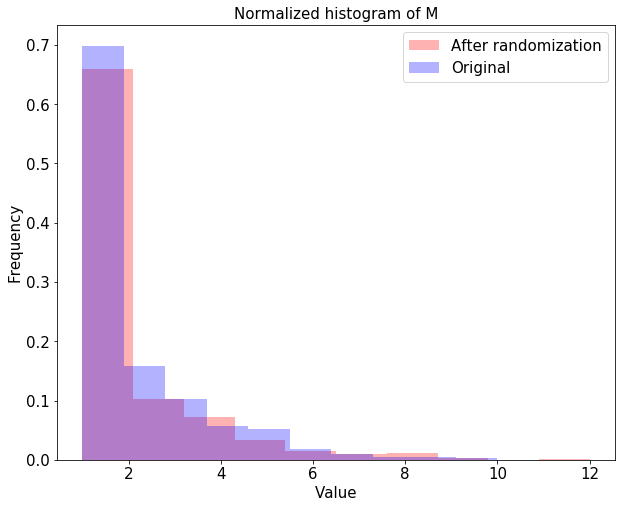

In [15]:
f=15
plt.figure(figsize=[10,8])
plt.hist(S_random,alpha=0.3,color='r',label='After randomization',density=True)
plt.hist(S_normal,alpha=0.3,color='b',label='Original',density=True)
plt.title('Normalized histogram of M',fontsize=f)
plt.xlabel('Value',fontsize=f)
plt.ylabel('Frequency',fontsize=f)
plt.legend(fontsize=f)
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)
a=plt.gcf()
a.savefig("C:/Users/wojci/Documents/Studia/praca/ZDEJCIA/not_random/normed_con_randomi2.jpg")
plt.show()

no stored variable S_random,


(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 <a list of 10 Text yticklabel objects>)

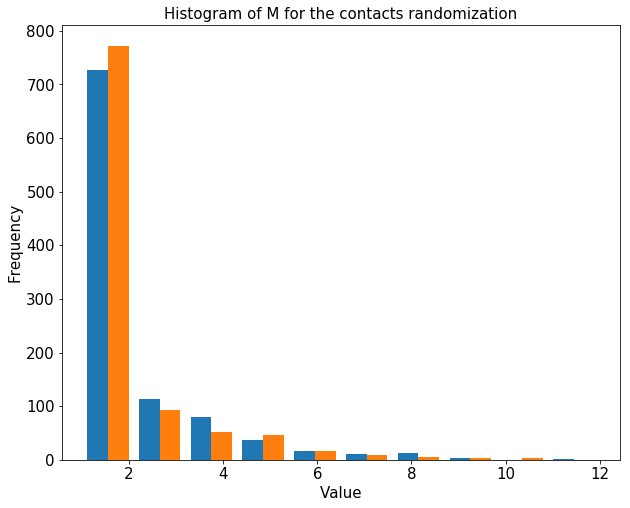

In [16]:
%store -r S_random, S_normal
plt.figure(figsize=[10,8])

plt.hist([S_random,S_normal])
"""xint = []
locs, labels = plt.xticks()
for each in locs:
    xint.append(int(each))

plt.xticks(np.arange(min(xint), max(xint)+1, 1.0))

#plt.xticks(xint)"""

#plt.hist(S_normal,alpha=0.3,color='b')
plt.title('Histogram of M for the contacts randomization',fontsize=f)
plt.xlabel('Value',fontsize=f)
plt.ylabel('Frequency',fontsize=f)
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)